In [1]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *


In [2]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))


loading alad


W1120 21:57:42.918161 139923038881600 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1120 21:57:42.952606 139923038881600 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 21:57:42.955391 139923038881600 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1120 21:57:42.956240 139923038881600 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16/config.py:81: dense (from tens

In [8]:
file_mc = '/home/oliverkn/pro/opendata_v2/b_mix_pre.hdf5'
file_ttbar = '/home/oliverkn/pro/opendata_v2/9588/data_pre.hdf5'

x_mc = h5py.File(file_mc, "r")['data']
x_ttbar = h5py.File(file_ttbar, "r")['data']


/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/oliverkn/pro/pycharm/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


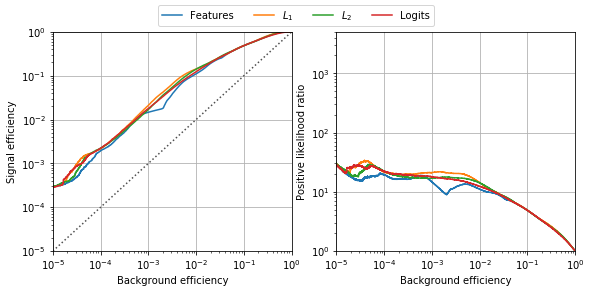

In [17]:
n_max = int(100e5)
fpr_lim = 1e-5
# 
x_mc_transformed = preprocessor.transform(x_mc[:n_max])
x_ttbar_transformed = preprocessor.transform(x_ttbar[:n_max])

mc_scores = ad.compute_all_scores(x_mc_transformed)
ttbar_scores = ad.compute_all_scores(x_ttbar_transformed)

y = np.concatenate([np.zeros_like(mc_scores[0]), np.ones_like(ttbar_scores[0])])
score_names = ['Features', r'$L_1$', r'$L_2$', 'Logits']

fig, ax_arr = plt.subplots(1, 2, figsize=(8, 4))

ax_arr[0].set(xlim=(fpr_lim, 1), ylim=(fpr_lim, 1))
ax_arr[0].set_xlabel('Background efficiency')
ax_arr[0].set_ylabel('Signal efficiency')
ax_arr[0].set_xscale('log')
ax_arr[0].set_yscale('log')
ax_arr[0].grid()

ax_arr[1].set(xlim=(fpr_lim, 1), ylim=(1, 5e3))
ax_arr[1].set_xlabel('Background efficiency')
ax_arr[1].set_ylabel('Positive likelihood ratio')
ax_arr[1].set_xscale('log')
ax_arr[1].set_yscale('log')
ax_arr[1].grid()

for j, name in enumerate(score_names):
    score = np.concatenate([mc_scores[j], ttbar_scores[j]])
    fpr, tpr, _ = roc_curve(y, score, pos_label=1)
    ax_arr[0].loglog(fpr, tpr, label=name)

    #plot LR+
    lrp = tpr/fpr
    ax_arr[1].step(fpr, lrp, label=name)

#plot diagonal line
ax_arr[0].plot(ax_arr[0].get_xlim(), ax_arr[0].get_ylim(), ls=":", c=".3")

handles, labels = ax_arr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', ncol=4)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=(0,0,1,0.93))

plt.savefig('figures/roc-tt.pdf')
plt.show()